目前你见过的所有神经网络（比如密集连接网络和卷积神经网络）都有一个主要特点，那就是它们都没有记忆。它们单独处理每个输入，在输入与输入之间没有保存任何状态。对于这样的网络，要想处理数据点的序列或时间序列，你需要向网络同时展示整个序列，即将序列转换成单个数据点。例如，你在 IMDB示例中就是这么做的：将全部电影评论转换为一个大向量，然后一次性处理。这种网络叫作前馈网络（feedforward network）。   

与此相反，当你在阅读这个句子时，你是一个词一个词地阅读（或者说，眼睛一次扫视一次扫视地阅读），同时会记住之前的内容。这让你能够动态理解这个句子所传达的含义。生物智能以渐进的方式处理信息，同时保存一个关于所处理内容的内部模型，这个模型是根据过去的信息构建的，并随着新信息的进入而不断更新。   

循环神经网络（RNN，recurrent  neural network）采用同样的原理，不过是一个极其简化的版本：它处理序列的方式是，遍历所有序列元素，并保存一个状态（state），其中包含与已查看内容相关的信息。实际上，RNN是一类具有内部环的神经网络（见图   6-9）。在处理两个不同的独立序列（比如两条不同的 IMDB评论）之间，RNN状态会被重置，因此，你仍可以将一个序列看作单个数据点，即网络的单个输入。真正改变的是，数据点不再是在单个步骤中进行处理，相反，网络内部会对序列元素进行遍历。



为了将环（loop）和状态的概念解释清楚，我们用 Numpy来实现一个简单  RNN的前向传递。这个 RNN的输入是一个张量序列，我们将其编码成大小为 (timesteps,  input_features)的二维张量。它对时间步（timestep）进行遍历，在每个时间步，它考虑 t时刻的当前状态与 t时刻的输入［形状为 (input_ features,)］，对二者计算得到t时刻的输出。然后，我们将下一个时间步的状态设置为上一个时间步的输出。对于第一个时间步，上一个时间步的输出没有定义，所以它没有当前状态。因此，你需要将状态初始化为一个全零向量，这叫作网络的初始状态（initial state）。



In [1]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# RNN 伪代码
state_t= 0 # t时刻的状态
for input_t in input_sequence: # 对序列元素进行遍历
    output_t= f(input_t, state_t) # f为自定义函数，从输入和状态到输出的变换，其参数一般包括两个矩阵(W和I)和一个偏置向量。
    state_t= output_t


In [ ]:
# RNN 伪代码详细版
state_t= 0 # t时刻的状态
for input_t in input_sequence: # 对序列元素进行遍历
    output_t= activation(dot(W, input_t)+dot(U, input_t)+b)
    state_t= output_t
    

In [4]:
# 简单RNN的Numpy实现
timesteps= 100 # 输入序列的时间步数
input_features= 32 # 输入特征空间的维度
output_features=64 # 输出特征空间的维度

inputs= np.random.random((timesteps, input_features))  ## 输入数据：随机噪声
state_t= np.zeros((output_features)) # 初始状态：全零向量

W= np.random.random((output_features, input_features)) # 创建随机的权重矩阵
U= np.random.random((output_features, output_features))
b= np.random.random((output_features))

successive_outputs=[]
for input_t in inputs:
    output_t= np.tanh(np.dot(W, input_t)+ np.dot(U, state_t)+b) # 由输入和当前状态(前一个输出)计算出当前输出# np.tanh= p.sinh(x)/np.cosh(x) 
                                                                # a=np.array([2,3,4]) b=np.array([3,4,5]) np.dot(a,b)=2*3+3*4+4*5
    successive_outputs.append(output_t) #将这个输出保存到一个列表中
    state_t=output_t
    
final_output_sequence= np.stack(successive_outputs,axis=0) #最终输出是一个形状为（timesteps，output_features）的二维张量


足够简单。总之，RNN是一个for循环，它重复使用循环前一次迭代的计算结果，仅此而已。当然，你可以构建许多不同的RNN，它们都满足上述定义。这个例子只是最简单的RNN表述之一。RNN的特征在于其时间步函数.   

本例中，最终输出是一个形状为(timesteps,  output_features)的二维张量，其中每个时间步是循环在 t时刻的输出。输出张量中的每个时间步 t包含输入序列中时间步0~t的信息，即关于全部过去的信息。因此，在多数情况下，你并不需要这个所有输出组成的序列，你只需要最后一个输出（循环结束时的 output_t），因为它已经包含了整个序列的信息。



### 6.2.1　Keras中的循环层



In [7]:
from tensorflow.keras.layers import SimpleRNN

二者有一点小小的区别： SimpleRNN层能够像其他   Keras层一样处理序列批量，而不是像 Numpy示例那样只能处理单个序列。因此，它接收形状为    (batch_size, timesteps,input_features)的输入，而不是(timesteps,  input_features)。

与 Keras中的所有循环层一样，SimpleRNN可以在两种不同的模式下运行：一种是返回每个时间步连续输出的完整序列，即形状为 (batch_size, timesteps, output_features)的三维张量；另一种是只返回每个输入序列的最终输出，即形状为  (batch_size, output_features)的二维张量。这两种模式由 return_sequences这个构造函数参数来控制。我们来看一个使用SimpleRNN的例子，它只返回最后一个时间步的输出。

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model= Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32)) # 添加 SimpleRNN
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。在这种情况下，你需要让所有中间层都返回完整的输出序列。
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True)) # 添加return_sequences则返回完整的状态序列。
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


接下来，我们将这个模型应用于 IMDB电影评论分类问题。首先，对数据进行预处理。



In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Loading data...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [6]:
#我们用一个Embedding层和一个SimpleRNN层来训练一个简单的循环网络。

from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 15s 89ms/step - loss: 0.6822 - acc: 0.5506 - val_loss: 0.5469 - val_acc: 0.7332
Epoch 2/10
157/157 [==============================] - 14s 86ms/step - loss: 0.4502 - acc: 0.8007 - val_loss: 0.4215 - val_acc: 0.8188
Epoch 3/10
157/157 [==============================] - 14s 86ms/step - loss: 0.3158 - acc: 0.8730 - val_loss: 0.4008 - val_acc: 0.8308
Epoch 4/10
157/157 [==============================] - 14s 86ms/step - loss: 0.2245 - acc: 0.9160 - val_loss: 0.4027 - val_acc: 0.8356
Epoch 5/10
157/157 [==============================] - 14s 86ms/step - loss: 0.1586 - acc: 0.9473 - val_loss: 0.4515 - val_acc: 0.8376
Epoch 6/10
157/157 [==============================] - 14s 89ms/step - loss: 0.0962 - acc: 0.9707 - val_loss: 0.7182 - val_acc: 0.7678
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.0646 - acc: 0.9803 - val_loss: 0.5582 - val_acc: 0.8206
Epoch 8/10
157/157 [==============================] - 14s 90ms

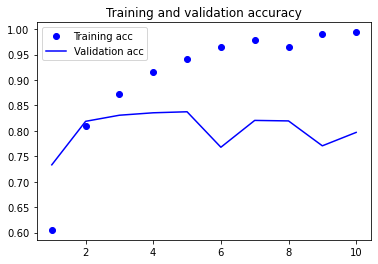

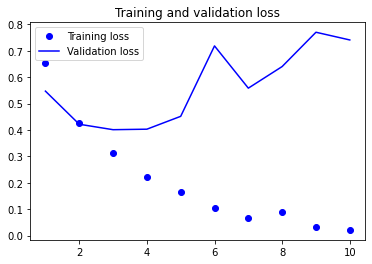

In [7]:
#显示训练和验证的损失和精度
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

在第 3章，处理这个数据集的第一个简单方法得到的测试精度是  88%。不幸的是，与这个基准相比，这个小型循环网络的表现并不好（验证精度只有 85%）。问题的部分原因在于，输入只考虑了前 500个单词，而不是整个序列，因此，RNN获得的信息比前面的基准模型更少。另一部分原因在于，SimpleRNN不擅长处理长序列，比如文本。



### 6.2.2　理解 LSTM层和 GRU层
LSTM层。其背后的长短期记忆（LSTM，long   short-term memory）, 是SimpleRNN层的一种变体，它增加了一种携带信息跨越多个时间步的方法。假设有一条传送带，其运行方向平行于你所处理的序列。序列中的信息可以在任意位置跳上传送带，然后被传送到更晚的时间步，并在需要时原封不动地跳回来。这实际上就是   LSTM的原理：它保存信息以便后面使用，从而防止较早期的信号在处理过程中逐渐消失。



In [ ]:
# SimpleRNN
y = activation(dot(state_t, U) + dot(input_t, W) + b)

In [ ]:
# LSTM
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo) # 多了一个dot(C_t, Vo)


i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

# 对i_t、f_t和k_t进行组合，可以得到新的携带状态（下一个c_t）。
c_(t+1) = i_t * k_t + c_t * f_t

# 作为人类，理解它不应该是你要做的。你只需要记住 LSTM单元的作用：允许过去的信息稍后重新进入，从而解决梯度消失问题。


### 6.2.3　Keras中一个  LSTM的具体例子
现在我们来看一个更实际的问题：使用  LSTM层来创建一个模型，然后在    IMDB数据上训练模型（见图  6-16和图 6-17）。这个网络与前面介绍的SimpleRNN网络类似。你只需指定LSTM层的输出维度，其他所有参数（有很多）都使用  Keras默认值。Keras具有很好的默认值，无须手动调参，模型通常也能正常运行。

In [8]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 29s 176ms/step - loss: 0.5931 - acc: 0.6812 - val_loss: 0.3478 - val_acc: 0.8554
Epoch 2/10
157/157 [==============================] - 25s 159ms/step - loss: 0.2973 - acc: 0.8845 - val_loss: 0.3476 - val_acc: 0.8512
Epoch 3/10
157/157 [==============================] - 26s 168ms/step - loss: 0.2300 - acc: 0.9171 - val_loss: 0.3098 - val_acc: 0.8656
Epoch 4/10
157/157 [==============================] - 26s 163ms/step - loss: 0.1969 - acc: 0.9318 - val_loss: 0.2966 - val_acc: 0.8796
Epoch 5/10
157/157 [==============================] - 26s 163ms/step - loss: 0.1771 - acc: 0.9356 - val_loss: 0.4911 - val_acc: 0.8360
Epoch 6/10
157/157 [==============================] - 25s 161ms/step - loss: 0.1548 - acc: 0.9463 - val_loss: 0.3442 - val_acc: 0.8828
Epoch 7/10
157/157 [==============================] - 25s 158ms/step - loss: 0.1379 - acc: 0.9527 - val_loss: 0.5131 - val_acc: 0.8286
Epoch 8/10
157/157 [==============================] - 2

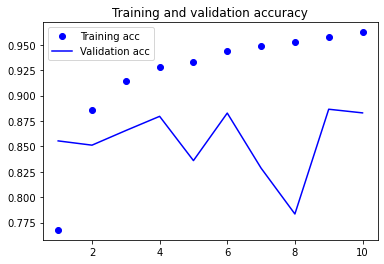

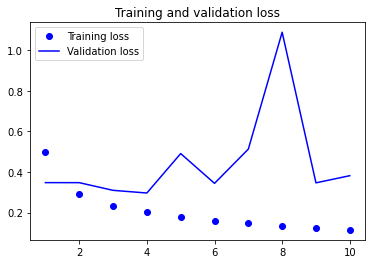

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

验证精度达到了  89%。还不错，肯定比 SimpleRNN网络好多了   

但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。为什么   LSTM不能表现得更好？   

一个原因是你没有花力气来调节超参数，比如嵌入维度或   LSTM输出维度。   

另一个原因可能是缺少正则化。   

但说实话，主要原因在于，适用于评论分析全局的长期性结构（这正是 LSTM所擅长的），对情感分析问题帮助不大。   

对于这样的基本问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。    

但还有更加困难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM的优势就明显了。

### 6.2.4　小结

现在你已经学会了以下内容。

循环神经网络（RNN）的概念及其工作原理。   

长短期记忆（LSTM）是什么，为什么它在长序列上的效果要好于普通  RNN。 因为LSTM允许过去的信息稍后重新进入，因此受梯度消失问题的影响要小的多。   

如何使用  Keras的  RNN层来处理序列数据。